In [1]:
import time
import json
import re
from collections import Counter
import hashlib

import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from birdy.twitter import UserClient
from birdy.twitter import TwitterRateLimitError
import datetime

# My own twitter profile

On this notebook I want to analyze my twitter profile and compare how what I read against what i retweet like and tweet.

## Retrieve the data

Before starting I need to retrieve the data from my own twitter use profile.

Using the light library [Birdy](https://github.com/inueni/birdy) to interact with the API

In [2]:
#create the client object
twitterCreds = json.load(open('twitterCreds.nogit'))
client = UserClient(twitterCreds['ConsumerKey'],
                    twitterCreds['ConsumerSecret'],
                    twitterCreds['AccessToken'],
                    twitterCreds['AccessTokenSecret'])

In [3]:
def get_tweet_from_user(screen_name):
    '''
    Function to retrive the last 1000 tweets of a person later than jan 2016.
    Expects the screen name as parameter
    '''
    tweets = []
    prev_last_id = None
    for i in range(5):
        try:
            response = client.api.statuses.user_timeline.get(screen_name=screen_name,
                                                             count=200,
                                                             trim_user=1,
                                                             max_id=prev_last_id,
                                                             since_id=681782785745502208,#jan 2016
                                                             include_rts=True)
        except TwitterRateLimitError:
            time.sleep(60*10)
            print('sleeping 10 minutes to recover rate limits')
        if len(response.data)==0:
            break
        last_id = response.data[-1]['id']
        if prev_last_id==last_id:
            break
        tweets += response.data
        prev_last_id = last_id
        time.sleep(1) #sleep avoid problems with the API.
    return(tweets)

In [4]:
#retrive my own users tweets
last_own_tweets = get_tweet_from_user('davidmartinb')
print(len(last_own_tweets))

992


In [5]:
#retrive all users with more than 100 tweets that I follow
all_users = []
next_cursor = None
for i in range(20):
    response = client.api.friends.list.get(screen_name='davidmartinb', cursor=next_cursor, count=200).data
    next_cursor = response['next_cursor']
    for user in response['users']:
        if user['statuses_count']>=100:
            all_users.append(user['screen_name'])
    if next_cursor==0:
        break
    time.sleep(1)
len(all_users)

1844

In [6]:
#I pick randomly 1/4 of the users and retrive their tweets.
all_users_last_tweets = {}
for i, user in enumerate(all_users):
    last_hashed_value = hashlib.sha224(user.encode('utf-8')).hexdigest()[-1]
    if last_hashed_value=='0' or last_hashed_value=='1' or last_hashed_value=='2'  or last_hashed_value=='3':
        print(i)
        all_users_last_tweets[user] = get_tweet_from_user(user)

0
4
9
10
11
14
17
20
24
26
28
32
35
39
40
41
42
43
44
46
49
57
58
59
60
61
82
84
85
87
91
94
97
105
110
113
120
140
141
148
155
159
162
177
180
183
187
188
191
196
209
210
219
220
233
239
253
255
259
263
269
270
271
274
281
283
285
292
296
301
302
303
304
314
315
326
327
335
338
342
343
344
345
350
352
358
359
360
362
365
367
374
376
377
379
391
395
401
407
411
412
413
416
418
426
428
432
436
442
443
445
447
454
455
462
463
471
474
478
479
482
484
491
493
494
503
506
508
510
513
516
517
521
528
530
532
535
538
539
550
556
559
560
565
575
587
596
597
598
606
612
615
616
618
623
634
636
637
647
648
663
667
669
673
676
677
681
683
690
698
706
712
718
730
732
733
743
753
754
756
759
770
772
773
777
778
780
783
789
794
796
797
803
804
805
812
815
819
821
822
823
824
832
837
844
852
854
857
859
860
861
862
863
867
868
870
872
873
875
878
881
885
886
891
892
893
894
906
907
908
910
911
921
925
926
927
929
934
937
938
939
948
950
955
956
957
958
966
971
973
974
975
978
984
986
987
996
998
1002

## Most Common words in my tweets

In [7]:
def get_unique_words(tweet):
    '''
    function to retrieve the top words in a tweet after cleaning the text.
    '''
    #get to rootest object
    if 'retweeted_status' in tweet:
        return get_unique_words(tweet['retweeted_status'])
    
    if 'quoted_status' in tweet:
        return get_unique_words(tweet['quoted_status'])
    text = tweet['text']
    
    #remove urls
    for url in tweet['entities'].get('urls', []) + tweet.get('extended_entities', {}).get('media', []):
        idx_from = url['indices'][0]
        idx_to = url['indices'][1]
        new_text = ''
        for idx in range(len(text)):
            if idx<idx_from or idx>idx_to:
                new_text += text[idx]
            else:
                new_text += ' '
        text = new_text

    text = text.lower() #all in lowercase
    
    #remove basic punctuation
    for c in '.…:|!‘“”()?¿~-/"—\n;,#':
        text = text.replace(c, ' ')
        
    # complex punctation
    text = text.replace('’ ', ' ') # close quotes
    
    #tokenize
    words = text.lower().split(' ')
    
    #all rt first word is always rt and second user
    if words[0]=='rt':
        words = words[2:]
    
    #clean empty words due to doble spaces
    words = [word for word in words if word!='']
    
    #clear mentions
    words = [word for word in words if not word[0]=='@']
    
    #return unique words per tweet
    words = list(set(words))
    return words


In [55]:
my_words = Counter()
for n, tweet in enumerate(last_own_tweets):
    dt = datetime.datetime.strptime(tweet['created_at'], "%a %b %d %H:%M:%S +0000 %Y")
    if dt>=datetime.datetime(2016,3,1):
        my_words.update(get_unique_words(tweet))
my_words.most_common(20)

[('the', 262),
 ('a', 231),
 ('of', 158),
 ('to', 154),
 ('in', 143),
 ('de', 136),
 ('is', 120),
 ('la', 105),
 ('and', 95),
 ('you', 83),
 ('this', 76),
 ('en', 76),
 ('el', 76),
 ('que', 75),
 ('i', 74),
 ('data', 65),
 ('for', 65),
 ('with', 61),
 ('on', 61),
 ('by', 56)]

In [56]:
print(datetime.datetime.strptime(tweet['created_at'], "%a %b %d %H:%M:%S +0000 %Y"))

2016-01-04 18:38:11


Most common words in my tweet are a combination of English, Spanish and Catalan stop words

## Language

In [57]:
languages = Counter()
for tweet in last_own_tweets:
    languages[tweet.get('lang', '')] += 1

In [58]:
languages.most_common(5)

[('en', 678), ('es', 209), ('und', 83), ('it', 6), ('pt', 4)]

Similarly my languages identified by twitter are first, English, then Spanish and then Unidentified (probably Catalan)

## Comparison

In [59]:
all_words = my_words.copy()
n_others_tweets = len(last_own_tweets)
for user, tweets in all_users_last_tweets.items():
    for tweet in tweets:
        dt = datetime.datetime.strptime(tweet['created_at'], "%a %b %d %H:%M:%S +0000 %Y")
        if dt>=datetime.datetime(2016,3,1):
            all_words.update(get_unique_words(tweet))
            n_others_tweets+=1

In [60]:
common_words = set(all_words.keys()) & set(my_words.keys())
words_info = []
for word in common_words:
    c_mine = my_words[word]
    p_mine = c_mine/len(last_own_tweets)
    logp_mine = np.log10(p_mine)
    c_all = all_words[word]
    p_all = c_all/n_others_tweets
    logp_all = np.log10(p_all)
    #if c_mine>5 and c_all>5:
    words_info.append([word, c_mine, p_mine, logp_mine, c_all, p_all, logp_all])

In [61]:
columns = ['word', 'c_mine','p_mine','logp_mine', 'c_all', 'p_all', 'logp_all']
words_info = pd.DataFrame(words_info, columns=columns).set_index('word')

In [68]:
p_mine = len(last_own_tweets)/n_others_tweets
words_info['pmi'] = np.log(words_info['c_mine']/n_others_tweets / (p_mine*words_info['p_all']))
words_info['pmi_c'] = words_info['pmi']*np.sqrt(words_info['c_all'])
words_info.sort_values('pmi_c', ascending=False)

,c_mine,p_mine,logp_mine,c_all,p_all,logp_all,pmi,pmi_c
word,,,,,,,,
dataviz,44,0.044355,-1.353059,2339,0.008170,-2.087803,1.691811,81.821419
the,262,0.264113,-0.578210,56624,0.197773,-0.703833,0.289257,68.830923
this,76,0.076613,-1.115698,12354,0.043149,-1.365026,0.574098,63.810214
is,120,0.120968,-0.917330,22742,0.079432,-1.100005,0.420623,63.431899
data,65,0.065524,-1.183598,9985,0.034875,-1.457485,0.630648,63.017519
python,23,0.023185,-1.634784,1470,0.005134,-2.289516,1.507577,57.801370
map,21,0.021169,-1.674292,713,0.002490,-2.603744,2.140141,57.146182
of,158,0.159274,-0.797855,33841,0.118198,-0.927390,0.298267,54.868968
than,24,0.024194,-1.616300,2337,0.008163,-2.088175,1.086531,52.525647


## Studing the corrected pointwise mutual information

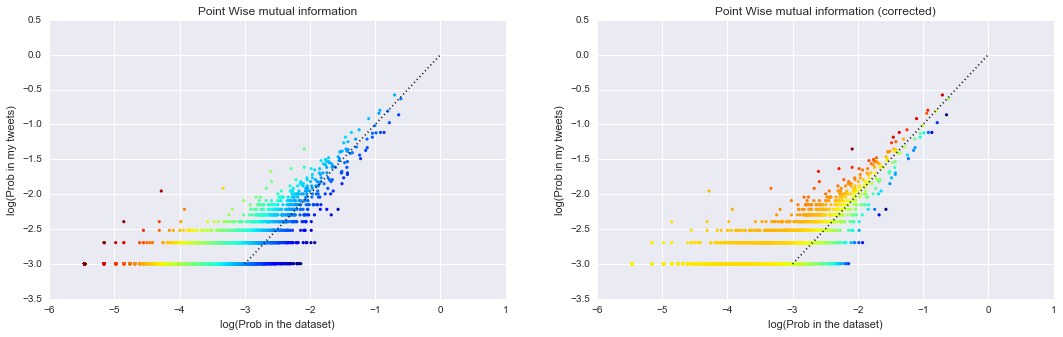

In [63]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.scatter(words_info['logp_all'], words_info['logp_mine'],10, words_info['pmi'],cmap='jet',lw=0)
plt.xlabel('log(Prob in the dataset)')
plt.ylabel('log(Prob in my tweets)')
plt.title('Point Wise mutual information')
plt.plot([-3, 0], [-3, 0], 'k:')
plt.subplot(1,2,2)
plt.scatter(words_info['logp_all'], words_info['logp_mine'],10, words_info['pmi_c'],cmap='jet',lw=0)
plt.xlabel('log(Prob in the dataset)')
plt.ylabel('log(Prob in my tweets)')
plt.title('Point Wise mutual information (corrected)')
plt.plot([-3, 0], [-3, 0], 'k:')
plt.show()

Not with the gradient how the PMI highlights another parts of the dataset than the corrected version of the PMI that reinforces non stop words